# Effect of varying maintenance cost on CUE

Microbes are believed to trade-off stress tolerance for biomass growth as stress increases. Here I will simulate the effect of stress on CUE using the "maintenance" cost incorporated into metabolic models as a proxy for stress tolerance

In [88]:
import cobra, gzip, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function

In [99]:
def read_gzip_smbl(filename):
    """
    Read a gzipped SMBL metabolic model
    """
    with gzip.open(filename) as fh:
        with tempfile.NamedTemporaryFile() as tf:
            tf.write(fh.read())
            model = cobra.io.read_sbml_model(tf.name)
    return model

def compute_cue(model):
    """
    Compute CUE using (uptake + secretion) / uptake definition
    https://github.com/michaelsilverstein/bf571_cue/blob/main/cue_tools.py#L169
    """
    # Get summary
    summary = model.summary()
    # Extract uptake and secrtion fluxes
    uptake  = summary._display_flux(summary.uptake_flux, True, 'C', 0)
    secretion = summary._display_flux(summary.secretion_flux, True, 'C', 0)
    # Get flux of C molecules
    uptake_c = (uptake.flux * uptake['C-Number']).sum()
    secretion_c = (secretion.flux * secretion['C-Number']).sum()
    # Compute CUE
    CUE = (uptake_c + secretion_c) / uptake_c
    return CUE

# Load 

In [27]:
"""Load model"""
model = read_gzip_smbl('../bigg_models/iJO1366.xml.gz')
model

Name,iJO1366
Memory address,0x02ac334ecb850
Number of metabolites,1805
Number of reactions,2583
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


# Varying ATP maintanenance cost

In [124]:
"""Range of ATP maintanenance costs"""
atpms = np.linspace(*cobra.flux_analysis.flux_variability_analysis(model, ['ATPM'], fraction_of_optimum=0).squeeze(), 25)

"""Compute CUE for range of costs"""
CUEs = []
for cost in atpms:
    with model as m:
        m.reactions.ATPM.bounds = cost, 1000
        CUE = compute_cue(m)
        CUEs.append(CUE)
cue_df = pd.DataFrame([{'cost': cost, 'cue': cue} for cost, cue in zip(atpms, CUEs)])
cue_df.head()

,cost,cue
0,3.150000,0.671998
1,12.810417,0.644590
2,22.470833,0.617181
3,32.131250,0.589772
4,41.791667,0.562363


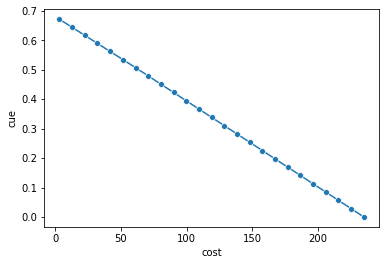

In [129]:
plt.figure(facecolor='w')
sns.lineplot(x='cost', y='cue', data=cue_df, marker='o')

plt.show()